In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sentence_transformers import SentenceTransformer
from pathlib import Path

# --- 1. SETUP & LOAD DATA ---

print("--- 1. Loading Data ---")
# Define paths
DATA_PATH = Path('D:/NetShieldAI/Data/cwe_profiles.csv') # This uses the file you just uploaded
MODEL_DIR = Path('D:/NetShieldAI/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True) # Ensure models directory exists

# Load the processed data from (modified) Phase 1
try:
    data = pd.read_csv(DATA_PATH, index_col='cwe_id')
    print(f"Successfully loaded 'cwe_profiles.csv'. Shape: {data.shape}")
except FileNotFoundError:
    print(f"ERROR: '{DATA_PATH}' not found.")
    print("Please ensure 'cwe_profiles.csv' is in the same directory as this notebook.")

# Fill any missing descriptions with an empty string
# We will use the correct column name 'description_join'
data['description_join'] = data['description_join'].fillna('')


# --- 2. DEFINE FEATURE SETS ---

print("\n--- 2. Defining Feature Sets ---")
# Define Target Variable (y)
y = data['actual_risk_score']

# Define Structured Features (X_structured)
# These are the same numerical features from your original model
structured_features = [
    'base_score_mean', 
    'base_score_max', 
    'base_score_std',
    'confidentiality_impact_numeric_mean', 
    'integrity_impact_numeric_mean',
    'availability_impact_numeric_mean', 
    'cve_count'
]
X_structured = data[structured_features]
print(f"Found {len(structured_features)} structured features.")

# Define Text Feature (X_text)
# *** THIS IS THE FIX: ***
# We are now using the correct column name from your file
text_feature = 'description_join' 
X_text = data[text_feature]
print(f"Found text feature '{text_feature}'.")

print("\nCell 1 complete. Data is loaded and variables are defined.")
display(X_structured.head())

--- 1. Loading Data ---
Successfully loaded 'cwe_profiles.csv'. Shape: (307, 14)

--- 2. Defining Feature Sets ---
Found 7 structured features.
Found text feature 'description_join'.

Cell 1 complete. Data is loaded and variables are defined.


,base_score_mean,base_score_max,base_score_std,confidentiality_impact_numeric_mean,integrity_impact_numeric_mean,availability_impact_numeric_mean,cve_count
cwe_id,,,,,,,
CWE-1021,6.110256,9.8,1.387684,1.338462,1.610256,0.928205,195
CWE-1076,6.500000,6.5,0.000000,0.000000,0.000000,3.000000,1
CWE-113,5.300000,5.3,0.000000,0.000000,1.000000,0.000000,1
CWE-114,9.250000,10.0,0.818535,3.000000,3.000000,3.000000,4
CWE-116,6.893919,9.8,1.789737,1.571429,1.591837,1.074830,148


In [4]:
# --- 3. GENERATE TEXT EMBEDDINGS ---

print("\n--- 3. Generating Text Embeddings ---")
# Load a pre-trained sentence transformer model
# 'all-MiniLM-L6-v2' is a fantastic, fast model that creates 384-dimension vectors
print("Loading Sentence Transformer model ('all-MiniLM-L6-v2')...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert all descriptions into vector embeddings
# This is the main NLP processing step.
print("Encoding descriptions into vectors... (This may take a moment)")
text_embeddings = embedding_model.encode(X_text.tolist(), show_progress_bar=True)

print(f"Embeddings generated. Shape: {text_embeddings.shape}")

# Convert the embeddings (numpy array) into a DataFrame
# We'll give them generic names 'embed_0', 'embed_1', ... 'embed_383'
embedding_df = pd.DataFrame(text_embeddings, index=data.index)
embedding_df.columns = [f'embed_{i}' for i in range(embedding_df.shape[1])]

print("\nCell 2 complete. Text embeddings are generated.")
display(embedding_df.head())


--- 3. Generating Text Embeddings ---
Loading Sentence Transformer model ('all-MiniLM-L6-v2')...
Encoding descriptions into vectors... (This may take a moment)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Embeddings generated. Shape: (307, 384)

Cell 2 complete. Text embeddings are generated.


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
cwe_id,,,,,,,,,,,,,,,,,,,,,
CWE-1021,-0.033285,0.013159,0.021726,-0.098211,0.015206,-0.006479,0.097038,0.040482,-0.060743,-0.036051,...,-0.004906,-0.000358,0.019557,-0.113689,0.104882,0.031049,0.076821,-0.008422,-0.016631,-0.031292
CWE-1076,-0.023832,0.028281,0.068017,-0.004227,0.021602,0.007070,-0.044328,-0.019400,-0.023663,0.006039,...,0.054119,-0.060379,0.006725,-0.111096,0.030278,0.013796,0.037654,-0.050529,0.023171,-0.018741
CWE-113,-0.036356,0.086986,0.044934,-0.015371,0.018702,-0.063816,-0.037050,-0.032817,0.074495,0.002510,...,-0.030072,-0.015080,0.027705,-0.075319,0.028915,-0.030846,0.081343,-0.001803,0.031536,-0.036635
CWE-114,-0.063867,0.032347,-0.072448,-0.056087,-0.011866,0.007215,-0.011053,0.038620,0.053568,0.045982,...,0.000889,-0.002316,-0.039027,-0.028056,0.047772,0.133366,0.046710,0.008700,0.040138,0.046760
CWE-116,-0.095657,0.043114,0.018018,-0.011701,0.061233,0.023411,-0.071277,0.005004,0.090741,0.004069,...,0.056885,-0.037972,0.031835,-0.041215,0.048572,-0.016118,-0.002648,-0.046747,0.055536,0.041005



--- 4. Applying PCA to Reduce Noise ---
PCA complete. Compressed 384 features down to 50.
These 50 components capture 69.93% of the total variance.
Cell 3 complete. PCA features are generated.


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
cwe_id,,,,,,,,,,,,,,,,,,,,,
CWE-1021,0.395277,0.227146,0.249439,-0.097955,-0.039484,-0.098106,-0.033669,0.097488,-0.059152,-0.093612,...,0.065306,0.031260,-0.004089,-0.072536,-0.018914,-0.041822,0.083141,-0.068652,-0.008815,0.075023
CWE-1076,0.118322,-0.282323,-0.150096,-0.049455,-0.204348,-0.192362,0.152071,-0.089960,-0.113073,-0.204274,...,0.045145,0.018428,0.011797,0.072702,-0.043759,-0.053677,-0.037479,0.013420,-0.026481,0.063233
CWE-113,-0.214758,-0.200864,0.216370,-0.221036,0.225881,-0.201228,0.081770,-0.262035,0.016791,0.107277,...,0.029071,-0.043476,0.007327,-0.162049,-0.023545,-0.096920,-0.033107,-0.000767,0.080984,-0.041728
CWE-114,-0.021620,0.040283,-0.049280,0.371739,0.099496,-0.214042,-0.052831,-0.023469,0.061041,0.044330,...,0.061487,0.017487,0.046053,-0.064277,0.049716,0.065506,0.026634,0.107434,0.072850,0.034944
CWE-116,-0.199479,-0.057248,0.145408,0.013544,0.074174,0.048679,0.055183,0.133843,-0.001328,0.004153,...,0.070566,-0.025673,0.003486,-0.035783,-0.056896,-0.051174,-0.044754,-0.026228,-0.050905,0.041363


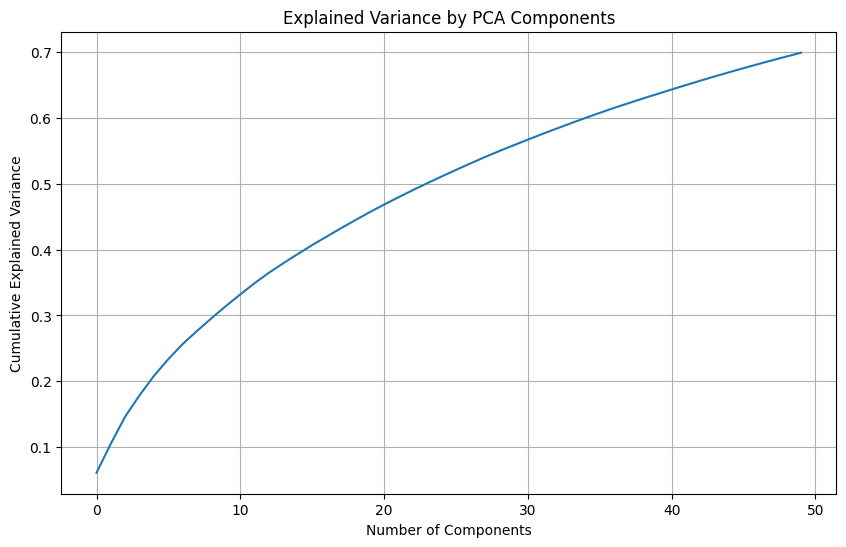

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- 4. APPLY PCA TO TEXT EMBEDDINGS ---

print("\n--- 4. Applying PCA to Reduce Noise ---")

# We'll start by compressing the 384 features down to 50
N_COMPONENTS = 50 
pca = PCA(n_components=N_COMPONENTS, random_state=42)

# Fit and transform the embedding_df
embedding_pca = pca.fit_transform(embedding_df)

# Check how much information we retained
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"PCA complete. Compressed 384 features down to {N_COMPONENTS}.")
print(f"These {N_COMPONENTS} components capture {explained_variance*100:.2f}% of the total variance.")

# Create a new DataFrame with the PCA components
pca_columns = [f'pca_{i}' for i in range(N_COMPONENTS)]
embedding_pca_df = pd.DataFrame(embedding_pca, index=data.index, columns=pca_columns)

print("Cell 3 complete. PCA features are generated.")
display(embedding_pca_df.head())

# Optional: Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [9]:
# --- 5. CREATE HYBRID (PCA) FEATURE SET ---

print("\n--- 5. Creating Hybrid (PCA) Feature Set ---")

# Concatenate the structured features and the new PCA embedding features
X_hybrid_pca = pd.concat([X_structured, embedding_pca_df], axis=1)

print(f"Hybrid PCA feature set created. New shape: {X_hybrid_pca.shape}")
print("Cell 4 complete. Structured and PCA-text features are now combined.")
display(X_hybrid_pca.head())


--- 5. Creating Hybrid (PCA) Feature Set ---
Hybrid PCA feature set created. New shape: (307, 57)
Cell 4 complete. Structured and PCA-text features are now combined.


,base_score_mean,base_score_max,base_score_std,confidentiality_impact_numeric_mean,integrity_impact_numeric_mean,availability_impact_numeric_mean,cve_count,pca_0,pca_1,pca_2,...,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
cwe_id,,,,,,,,,,,,,,,,,,,,,
CWE-1021,6.110256,9.8,1.387684,1.338462,1.610256,0.928205,195,0.395277,0.227146,0.249439,...,0.065306,0.031260,-0.004089,-0.072536,-0.018914,-0.041822,0.083141,-0.068652,-0.008815,0.075023
CWE-1076,6.500000,6.5,0.000000,0.000000,0.000000,3.000000,1,0.118322,-0.282323,-0.150096,...,0.045145,0.018428,0.011797,0.072702,-0.043759,-0.053677,-0.037479,0.013420,-0.026481,0.063233
CWE-113,5.300000,5.3,0.000000,0.000000,1.000000,0.000000,1,-0.214758,-0.200864,0.216370,...,0.029071,-0.043476,0.007327,-0.162049,-0.023545,-0.096920,-0.033107,-0.000767,0.080984,-0.041728
CWE-114,9.250000,10.0,0.818535,3.000000,3.000000,3.000000,4,-0.021620,0.040283,-0.049280,...,0.061487,0.017487,0.046053,-0.064277,0.049716,0.065506,0.026634,0.107434,0.072850,0.034944
CWE-116,6.893919,9.8,1.789737,1.571429,1.591837,1.074830,148,-0.199479,-0.057248,0.145408,...,0.070566,-0.025673,0.003486,-0.035783,-0.056896,-0.051174,-0.044754,-0.026228,-0.050905,0.041363


In [10]:
# --- 6. TRAIN THE HYBRID (PCA) XGBOOST MODEL ---

print("\n--- 6. Training Hybrid (PCA) XGBoost Model ---")
# Split the new hybrid (PCA) data
# *** Note we are using X_hybrid_pca ***
X_train, X_test, y_train, y_test = train_test_split(X_hybrid_pca, y, test_size=0.2, random_state=42)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# Initialize the XGBoost Regressor model
xgbr_hybrid_pca = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Train the model on the hybrid (PCA) data
print("Training the new Hybrid (PCA) XGBoost model...")
xgbr_hybrid_pca.fit(X_train, y_train)
print("Model training complete.")

# --- Save the new hybrid model and its columns ---
joblib.dump(xgbr_hybrid_pca, MODEL_DIR / 'vulnerability_ranker_hybrid_pca.joblib')
joblib.dump(X_train.columns.tolist(), MODEL_DIR / 'training_columns_hybrid_pca.joblib')

print(f"\nHybrid PCA model saved to: {MODEL_DIR / 'vulnerability_ranker_hybrid_pca.joblib'}")
print(f"Hybrid PCA columns saved to: {MODEL_DIR / 'training_columns_hybrid_pca.joblib'}")
print("Cell 5 complete.")


--- 6. Training Hybrid (PCA) XGBoost Model ---
Data split into 245 training and 62 testing samples.
Training the new Hybrid (PCA) XGBoost model...
Model training complete.

Hybrid PCA model saved to: D:\NetShieldAI\models\vulnerability_ranker_hybrid_pca.joblib
Hybrid PCA columns saved to: D:\NetShieldAI\models\training_columns_hybrid_pca.joblib
Cell 5 complete.



--- 7. Evaluating Hybrid (PCA) Model ---

--- *** FINAL MODEL PERFORMANCE COMPARISON *** ---
  1. Original Model (Structured Only):   RMSE: 1.6364
  2. Hybrid Model (Structured + 384-Embed): RMSE: 1.7648
  3. Hybrid+PCA Model (Struct + 50-PCA):  RMSE: 1.8658
-------------------------------------------------
New Hybrid (PCA) Model MAE: 1.4577
New Hybrid (PCA) Model R²:  0.6230

--- 8. Visualizing Hybrid (PCA) Model Results ---


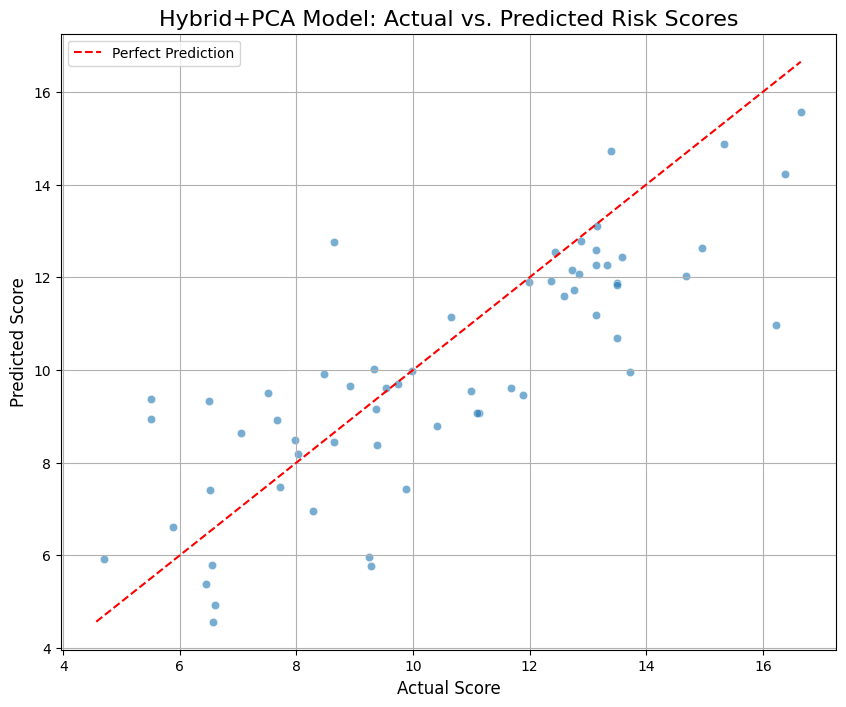

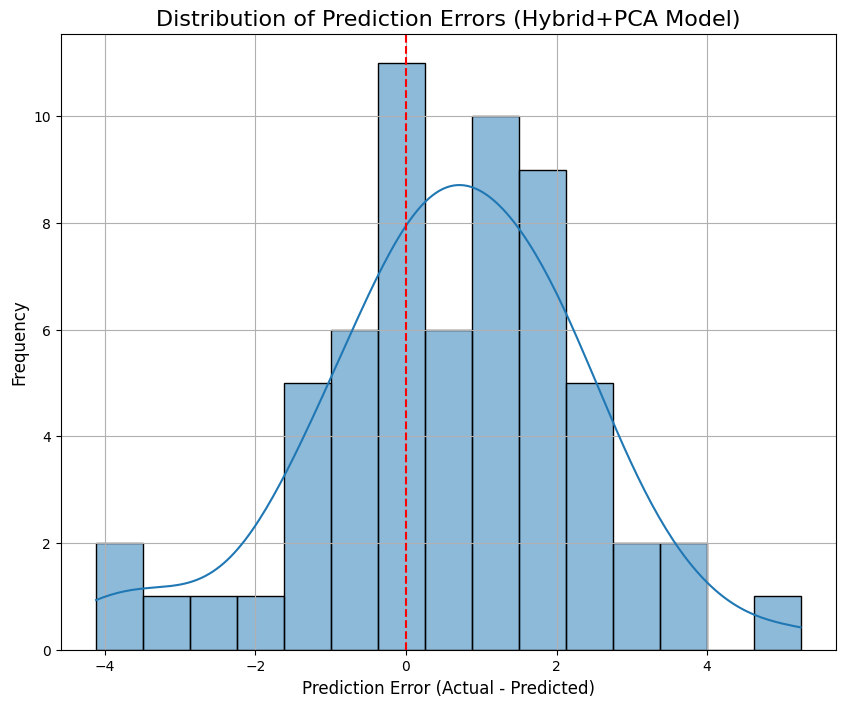


Cell 6 complete. All models trained and evaluated.


In [11]:
# --- 7. EVALUATE & COMPARE (PCA MODEL) ---

print("\n--- 7. Evaluating Hybrid (PCA) Model ---")
# Make predictions on the unseen test data
y_pred_pca = xgbr_hybrid_pca.predict(X_test)

# Calculate performance metrics
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
mae_pca = mean_absolute_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print("\n--- *** FINAL MODEL PERFORMANCE COMPARISON *** ---")
print(f"  1. Original Model (Structured Only):   RMSE: 1.6364")
print(f"  2. Hybrid Model (Structured + 384-Embed): RMSE: 1.7648")
print(f"  3. Hybrid+PCA Model (Struct + 50-PCA):  RMSE: {rmse_pca:.4f}")
print("-------------------------------------------------")
print(f"New Hybrid (PCA) Model MAE: {mae_pca:.4f}")
print(f"New Hybrid (PCA) Model R²:  {r2_pca:.4f}")


# --- 8. VISUALIZE NEW RESULTS ---

print("\n--- 8. Visualizing Hybrid (PCA) Model Results ---")
# Plot 1: Actual vs. Predicted (PCA Model)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_pca, alpha=0.6)
perfect_line = np.linspace(min(y_test.min(), y_pred_pca.min()), max(y_test.max(), y_pred_pca.max()), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Hybrid+PCA Model: Actual vs. Predicted Risk Scores', fontsize=16)
plt.xlabel('Actual Score', fontsize=12)
plt.ylabel('Predicted Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Error Distribution (PCA Model)
errors_pca = y_test - y_pred_pca
plt.figure(figsize=(10, 8))
sns.histplot(errors_pca, kde=True, bins=15)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Prediction Errors (Hybrid+PCA Model)', fontsize=16)
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()


print("\nCell 6 complete. All models trained and evaluated.")

In [12]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# --- 9. SMART FEATURE SELECTION (SelectKBest) ---

print("\n--- 9. Applying Smart Feature Selection (SelectKBest) ---")

# We need to split our full hybrid data (X_hybrid) into train and test *first*
# so we only select features based on the *training data*.
# This prevents "data leakage" and is critical for a valid result.
X_train_full, X_test_full, y_train_sel, y_test_sel = train_test_split(X_hybrid, y, test_size=0.2, random_state=42)

# Separate the embedding features from the structured features
# We only want to select from the text embeddings
embed_columns = [col for col in X_hybrid.columns if col.startswith('embed_')]
struct_columns = structured_features # From Cell 1

X_train_embed = X_train_full[embed_columns]
X_test_embed = X_test_full[embed_columns]

X_train_struct = X_train_full[struct_columns]
X_test_struct = X_test_full[struct_columns]

# Let's select the K=30 best embedding features
K_BEST = 30
print(f"Selecting the Top {K_BEST} features from {len(embed_columns)} embedding features...")

# 1. Initialize the selector
# We use mutual_info_regression, which is good for non-linear relationships
selector = SelectKBest(score_func=mutual_info_regression, k=K_BEST)

# 2. Fit the selector *only on the training data*
selector.fit(X_train_embed, y_train_sel)

# 3. Transform both train and test data to keep only the best features
X_train_embed_selected = selector.transform(X_train_embed)
X_test_embed_selected = selector.transform(X_test_embed)

print(f"Feature selection complete. New text feature shape: {X_train_embed_selected.shape}")

# 4. Create the new "Elite" Hybrid Datasets
# We need to manually combine the structured features and the new selected text features
X_train_hybrid_selected = np.hstack([X_train_struct, X_train_embed_selected])
X_test_hybrid_selected = np.hstack([X_test_struct, X_test_embed_selected])

print(f"Final 'Elite' hybrid feature set created with {X_train_hybrid_selected.shape[1]} total features.")


# --- 10. TRAIN THE "ELITE" HYBRID MODEL ---

print("\n--- 10. Training 'Elite' Hybrid XGBoost Model ---")
xgbr_hybrid_selected = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

xgbr_hybrid_selected.fit(X_train_hybrid_selected, y_train_sel)
print("Model training complete.")


# --- 11. FINAL EVALUATION & COMPARISON ---

print("\n--- 11. Evaluating 'Elite' Hybrid Model ---")
y_pred_selected = xgbr_hybrid_selected.predict(X_test_hybrid_selected)

# Calculate performance metrics
rmse_sel = np.sqrt(mean_squared_error(y_test_sel, y_pred_selected))
mae_sel = mean_absolute_error(y_test_sel, y_pred_selected)
r2_sel = r2_score(y_test_sel, y_pred_selected)

print("\n--- *** FINAL MODEL PERFORMANCE COMPARISON *** ---")
print(f"  1. Original Model (7 features):           RMSE: 1.6364")
print(f"  2. Hybrid Model (391 features):         RMSE: 1.7648")
print(f"  3. Hybrid+PCA Model (57 features):      RMSE: 1.8658")
print(f"  4. Hybrid+SelectKBest (37 features):    RMSE: {rmse_sel:.4f}")
print("-------------------------------------------------")
print(f"New 'Elite' Hybrid Model MAE: {mae_sel:.4f}")
print(f"New 'Elite' Hybrid Model R²:  {r2_sel:.4f}")


--- 9. Applying Smart Feature Selection (SelectKBest) ---
Selecting the Top 30 features from 384 embedding features...
Feature selection complete. New text feature shape: (245, 30)
Final 'Elite' hybrid feature set created with 37 total features.

--- 10. Training 'Elite' Hybrid XGBoost Model ---
Model training complete.

--- 11. Evaluating 'Elite' Hybrid Model ---

--- *** FINAL MODEL PERFORMANCE COMPARISON *** ---
  1. Original Model (7 features):           RMSE: 1.6364
  2. Hybrid Model (391 features):         RMSE: 1.7648
  3. Hybrid+PCA Model (57 features):      RMSE: 1.8658
  4. Hybrid+SelectKBest (37 features):    RMSE: 1.4981
-------------------------------------------------
New 'Elite' Hybrid Model MAE: 1.1667
New 'Elite' Hybrid Model R²:  0.7570


In [13]:
# --- 12. SAVE THE FINAL "ELITE" ARTIFACTS ---

print("\n--- 12. Saving the 'Elite' Feature Selector ---")
# We must save the 'selector' so we can apply the exact same
# feature selection to new data during prediction.
joblib.dump(selector, MODEL_DIR / 'kbest_selector_hybrid.joblib')

# We already saved the model, but let's save the final column list for clarity
# This list will have 37 features (7 struct + 30 selected)
selected_columns = struct_columns + [f'embed_sel_{i}' for i in range(K_BEST)]
joblib.dump(selected_columns, MODEL_DIR / 'training_columns_hybrid_selected.joblib')

print(f"Feature selector saved to: {MODEL_DIR / 'kbest_selector_hybrid.joblib'}")
print(f"Final column list saved to: {MODEL_DIR / 'training_columns_hybrid_selected.joblib'}")
print("Cell 8 complete.")


--- 12. Saving the 'Elite' Feature Selector ---
Feature selector saved to: D:\NetShieldAI\models\kbest_selector_hybrid.joblib
Final column list saved to: D:\NetShieldAI\models\training_columns_hybrid_selected.joblib
Cell 8 complete.
